## Ensemble de árboles de decisión

Los emsambles son métodos que combinan múltiples modelos de aprendizaje automático para crear modelos más potentes. Hay muchos modelos en la literatura del machine learning  que pertenecen a esta categoría, pero hay dos modelos de este  conjunto que han demostrado ser efectivos en una amplia gama de conjuntos de datos para clasificación y regresión, los cuales usan árboles de decisión como bloques de construcción: bosques aleatorios y gradient boosting  de árboles de decisión.


### Bosques aleatorios

Un bosque aleatorio es esencialmente una colección de árboles de decisión, donde cada árbol es ligeramente diferente de los otros. La idea detrás de los bosques aleatorios es que cada árbol podría hacer un trabajo relativamente bueno de predicción, pero es probable que se sobreajuste en parte de los datos. Si construimos muchos árboles, todos los cuales funcionan bien y se sobreajustan de diferentes maneras, podemos reducir la cantidad de sobreajuste promediando sus resultados. 
Esta reducción en el sobreajuste, a la vez que conserva el poder predictivo de los árboles, puede demostrarse utilizando matemáticas.

Para implementar esta estrategia, necesitamos construir muchos árboles de decisión. Cada árbol debe hacer un trabajo aceptable de predicción del objetivo, y también debe ser diferente de los otros árboles. Los bosques aleatorios reciben su nombre al inyectar aleatoriedad en la construcción del árbol para garantizar que cada árbol sea diferente. Hay dos formas en que los árboles en un bosque aleatorio son aleatorizados: seleccionando los puntos de datos usados para construir un árbol y seleccionando las características en cada división de la prueba.

### Construyendo bosques aleatorios

Para construir un modelo de bosque aleatorio, se debe decidir la cantidad de árboles que se construirán (el parámetro `n_estimators` de `RandomForestRegressor` o `RandomForestClassifier`). Estos árboles se construirán de forma completamente independiente el uno del otro, y el algoritmo hará diferentes elecciones aleatorias para cada árbol para asegurarse de que los árboles sean distintos. 

Para construir un árbol, primero tomamos lo que se llama una muestra `bootstrap` de nuestros datos. Es decir,  `n_samples` puntos de datos, repetidamente sacamos  un ejemplo al azar con reemplazo (lo que significa que la misma muestra se puede recoger varias veces), `n_samples` veces. Esto creará un conjunto de datos que es tan grande como el conjunto de datos original, pero faltarán algunos puntos de datos (aproximadamente un tercio), y algunos se repetirán.
A continuación, se construye un árbol de decisión basado en este conjunto de datos recién creado. Sin embargo, el algoritmo que describimos para el árbol de decisión está ligeramente modificado. En lugar de buscar la mejor prueba para cada nodo, en cada nodo el algoritmo selecciona aleatoriamente un subconjunto de las características y busca la mejor prueba posible que involucre una de estas características. La cantidad de características que se seleccionan está controlada por el parámetro `max_features`. Esta selección de un subconjunto de características se repite por separado en cada nodo, de modo que cada nodo en un árbol puede tomar una decisión utilizando un subconjunto diferente de las características.

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(X, y, stratify=y,
random_state=42)
bosque_aleatorio = RandomForestClassifier(n_estimators=5, random_state=2)
bosque_aleatorio.fit(X_entrenamiento, y_entrenamiento)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=2, verbose=0, warm_start=False)

Los árboles que se construyen como parte del bosque aleatorio se almacenan en el atributo `estimator_`. Visualicemos las fronteras  de decisión aprendidos por cada árbol, junto con la predicción agregada tal como la hizo el bosque aleatorio.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import matplotlib as mpl
from matplotlib.colors import  colorConverter, ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def dibuja_dispersion_discreta(x1, x2, y=None, marcadores=None, s=10, ax=None,
                     etiquetas=None, relleno=.2, alfa=1, c=None, anchobordemarcador=None):
    """Adaptacion de la funcion matplotlib.pyplot.scatter a dibujar clases o  clusters"""
    
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unico_y = np.unique(y)

    if marcadores is None:
        marcadores= ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(marcadores) == 1:
        marcadores = marcadores * len(unico_y)

    if etiquetas is None:
        etiquetas = unico_y

    # lineas en el sentido de matplotlib
    lineas = []

    actual_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unico_y, actual_cycler())):
        mascara = y == yy
        # if c is ninguno, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # bordes claros para marcadores oscuros
        if np.mean(colorConverter.to_rgb(color)) < .4:
            colorbordemarcador = "grey"
        else:
            colorbordemarcador = "black"

        lineas.append(ax.plot(x1[mascara], x2[mascara], marcadores[i], markersize=s,
                             label=etiquetas[i], alpha=alfa, c=color,
                             markeredgewidth=anchobordemarcador,
                             markeredgecolor=colorbordemarcador)[0])

    if relleno != 0:
        pad1 = x1.std() * relleno
        pad2 = x2.std() * relleno
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lineas

Utilizamos las funciones usadas anteriormente con los árboles de decisión.

In [3]:
def dibuja_arbol_particion(X, y, arbol, ax=None):
    if ax is None:
        ax = plt.gca()
    eps = X.std() / 2.

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]

    Z = arbol.predict(X_grid)
    Z = Z.reshape(X1.shape)
    caras = arbol.apply(X_grid)
    caras = caras.reshape(X1.shape)
    bordes = ndimage.laplace(caras) != 0
    ax.contourf(X1, X2, Z, alpha=.4, cmap=cm2, levels=[0, .5, 1])
    ax.scatter(X1[bordes], X2[bordes], marker='.', s=1)

    dibuja_dispersion_discreta(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    return ax

Dibujamos un separador en el plano de dos dimensiones.

In [4]:
def dibuja_separador_2d(clasificador, X, relleno=False, ax=None, eps=None, alfa=1,
                      cm=cm2, ancholinea=None, umbral=None,
                      estilolinea="solid"):

    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 1000)
    yy = np.linspace(y_min, y_max, 1000)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        valor_decision = clasificador.decision_function(X_grid)
        niveles = [0] if umbral is None else [umbral]
        niveles_f = [valor_decision.min()] + niveles + [valor_decision.max()]
    except AttributeError:
        # No funciones de decision
        valor_decision = clasificador.predict_proba(X_grid)[:, 1]
        niveles = [.5] if umbral is None else [umbral]
        niveles_f = [0] + niveles + [1]
    if relleno:
        ax.contourf(X1, X2, valor_decision.reshape(X1.shape),
                    levels=niveles_f, alpha=alfa, cmap=cm)
    else:
        ax.contour(X1, X2, valor_decision.reshape(X1.shape), levels=niveles,
                   colors="black", alpha=alfa, linewidths=ancholinea,
                   linestyles=estilolinea, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())

El muestreo bootstrap conduce a cada árbol de decisión en el bosque aleatorio que se construye en un conjunto de datos ligeramente diferente. Debido a la selección de características en cada nodo, cada división en cada árbol opera en un subconjunto diferente de características. Juntos, estos dos mecanismos aseguran que todos los árboles en el bosque aleatorio sean diferentes.

Un parámetro crítico en este proceso es `max_features`. Si establecemos `max_features` en `n_features`, eso significa que cada división puede ver todas las características en el conjunto de datos y no se inyectará aleatoriedad en la selección de características (sin embargo, la aleatoriedad debido al bootstrapping permanece). Si establecemos `max_features` en 1, eso significa que las divisiones no tienen opción en absoluto sobre qué característica probar  y solo puede buscar sobre umbrales diferentes para la característica que fue seleccionada al azar.  Por lo tanto, un `max_features` alto significa que los árboles en el bosque aleatorio serán bastante similares, y podrán ajustar los datos fácilmente, utilizando las características más distintivas. Un `max_features` bajo significa que los árboles en el bosque aleatorio serán bastante diferentes  y que cada árbol debe ser muy profundo para poder encajar bien con los datos.

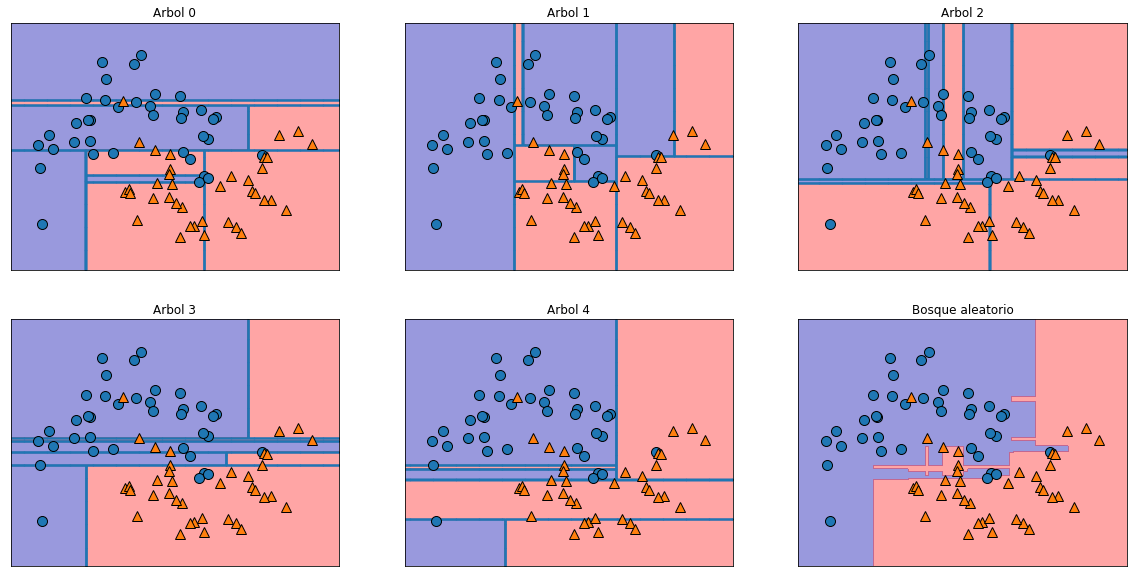

In [5]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, arbol) in enumerate(zip(axes.ravel(), bosque_aleatorio.estimators_)):
    ax.set_title("Arbol {}".format(i))
    dibuja_arbol_particion(X_entrenamiento, y_entrenamiento, arbol, ax=ax)
    
dibuja_separador_2d(bosque_aleatorio, X_entrenamiento, relleno=True, ax=axes[-1, -1], alfa=.4)
axes[-1, -1].set_title("Bosque aleatorio")
dibuja_dispersion_discreta(X_entrenamiento[:, 0], X_entrenamiento[:, 1], y_entrenamiento)

Para hacer una predicción usando bosques aleatorios, el algoritmo primero hace una predicción para cada árbol en el bosque. Para la regresión, podemos promediar estos resultados para obtener nuestra predicción final. Para la clasificación, se usa una estrategia de `soft voting`. Esto significa que cada algoritmo realiza una predicción "suave", proporcionando una probabilidad para cada etiqueta de salida posible.

Se promedian las probabilidades predichas por todos los árboles y se predice la clase con la probabilidad más alta.

Las fronteras de decisión aprendidos por los cinco árboles son bastante diferentes. Cada uno de ellos cometen algunos errores, ya que algunos de los puntos de entrenamiento que se dibujaron  aquí no se incluyeron realmente en los conjuntos de entrenamiento de los árboles, debido al muestreo bootstrap.

El bosque aleatorio sobreajusta menos que a  cualquiera de los árboles individualmente  y proporciona una frontera de decisión mucho más intuitivo. En cualquier aplicación real, usaríamos muchos más árboles (a menudo cientos o miles), lo que llevaría a fronteras  aún más suaves.

#### Ejemplo

 Apliquemos un bosque aleatorio que consta de 100 árboles en el conjunto de datos `Breast Cancer`:

In [6]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(cancer.data, 
                                                cancer.target, random_state=0)
bosque_aleatorio1 = RandomForestClassifier(n_estimators=100, random_state=0)
bosque_aleatorio1.fit(X_entrenamiento, y_entrenamiento)
print("Precision del conjunto de entrenamiento: {:.3f}".format(bosque_aleatorio1.score(X_entrenamiento, y_entrenamiento)))
print("Precision del conjunto de prueba: {:.3f}".format(bosque_aleatorio1.score(X_prueba, y_prueba)))

Precision del conjunto de entrenamiento: 1.000
Precision del conjunto de prueba: 0.972


El bosque aleatorio nos da una precisión del 97%, mejor que los modelos lineales o un solo árbol de decisión, sin ajustar ningún parámetro. Podríamos ajustar la configuración `max_fetures`, o aplicar pre-poda como lo hicimos para un árbol de decisión. Sin embargo, a menudo los parámetros predeterminados del bosque aleatorio ya funcionan bastante bien.

De forma similar a un  árbol de decisión, un  bosque aleatorio proporciona importancias de características, que se calculan al agregar las importancias de las características sobre los árboles en el bosque. Normalmente, las características proporcionadas por el bosque aleatorio son más confiables que las proporcionadas por un solo árbol de decisión.

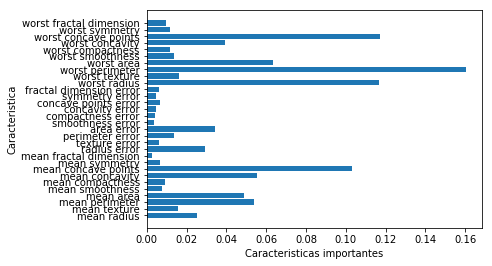

In [7]:
def dibuja_caracteristicas_importantes_cancer(modelo):
    n_caracteristica = cancer.data.shape[1]
    plt.barh(range(n_caracteristica), modelo.feature_importances_, align='center')
    plt.yticks(np.arange(n_caracteristica), cancer.feature_names)
    plt.xlabel("Caracteristicas importantes")
    plt.ylabel("Caracteristica")
dibuja_caracteristicas_importantes_cancer(bosque_aleatorio1)

Un  bosque aleatorio otorga una importancia distinta de cero a muchas más características que un  árbol de decisión individual. De forma similar a un  árbol de decisión único, el bosque aleatorio también le da mucha importancia a la característica a `worst_radius`, pero en realidad elige el `worst_perimeter` como la característica más informativa en general. 

La aleatoriedad en la construcción del bosque aleatorio obliga al algoritmo a considerar muchas explicaciones posibles y el resultado es que el bosque aleatorio captura una imagen mucho más amplia de los datos que un solo árbol de decisión.

### Fortalezas, debilidades y paramétros


Si bien la creación de bosques aleatorios en conjuntos de datos de gran tamaño puede consumir bastante tiempo, se puede paralelizar en múltiples núcleos de CPU dentro de una computadora fácilmente. 
Si se está utilizando un procesador multicore (como lo hacen casi todas las computadoras modernas), puede usar el parámetro `n_jobs` para ajustar la cantidad de núcleos que se usarán. 

Usar más núcleos de CPU dará como resultado aceleraciones lineales (usando dos núcleos, el entrenamiento del bosque aleatorio será el doble de rápido), pero especificar `n_jobs` más grande que el número de núcleos no ayudará. Puedes establecer `n_jobs = -1` para usar todos los núcleos en tu computadora.

Debe tener en cuenta que los bosques aleatorios, por su naturaleza, son aleatorios, y establecer diferentes estados aleatorios  puede cambiar drásticamente el modelo que se construye. Cuantos más árboles haya en el bosque, más robusto será contra la elección del estado aleatorio. Si desea tener resultados reproducibles, es importante corregir el paramétro `random_state`.

Los bosques aleatorios no suelen tener un buen rendimiento en datos dispersos de altas dimensiones, como datos de texto. Para este tipo de datos, los modelos lineales podrían ser más apropiados. Los bosques aleatorios generalmente funcionan bien incluso en conjuntos de datos grandes  y el entrenamiento se puede paralelizar fácilmente en muchos núcleos de CPU dentro de una computadora poderosa.  Sin embargo, los bosques aleatorios requieren más memoria y son más lentos para entrenar y predecir que los modelos lineales. Si el tiempo y la memoria son importantes en una aplicación, podría tener sentido utilizar un modelo lineal.

Los parámetros importantes para ajustar son `n_estimators`, `max_features` y posiblemente opciones previas a la poda como `max_depth`. Para `n_estimators`, más grande es siempre mejor.  Promediar más árboles producirá un conjunto más robusto al reducir el sobreajuste. Sin embargo, hay rendimientos decrecientes y más árboles necesitan más memoria y más tiempo para entrenar.

Una regla empírica común es construir `tantos como tengas tiempo/memoria`, además como se describió anteriormente, `max_features` determina qué tan aleatorio es cada árbol y tener  un  `max_features` más pequeño reduce el sobreajuste. En general, es una buena regla general usar los valores predeterminados: `max_features = sqrt (n_features)` para la clasificación y `max_features = log2(n_features)` para la regresión. 
Agregar `max_features` o `max_leaf_nodes` a veces puede mejorar el rendimiento. También puede reducir drásticamente los requisitos de espacio y tiempo para el entrenamiento y la predicción.




### Gradient Boosting

La idea principal detrás del modelo Gradient Boosting es combinar muchos modelos simples (en este contexto conocidos como `weak learners`), como árboles poco profundos. Cada árbol solo puede proporcionar buenas predicciones sobre parte de los datos, por lo que cada vez se agregan más árboles para mejorar el rendimiento iterativamente.

El gradient boosting de árboles son con frecuencia los ganadores en las competiciones de machine learning y son ampliamente utilizados en la industria. En general, son un poco más sensibles a la configuración de parámetros que los bosques aleatorios, pero pueden proporcionar una mayor precisión si los parámetros están configurados correctamente.

Además de la poda previa y la cantidad de árboles en el conjunto, otro parámetro importante del gradient boosting  es `learning_rate`, que controla como cada árbol intenta corregir los errores de los árboles anteriores. Una tasa de aprendizaje más alta significa que cada árbol puede hacer correcciones más fuertes, lo que permite modelos más complejos.
Agregar más árboles al conjunto, lo que se puede lograr aumentando `n_estimators`, también aumenta la complejidad del modelo, ya que el modelo tiene más oportunidades de corregir errores en el conjunto de entrenamiento.

#### Ejemplo

Usemos el clasificador `GradientBoostingClassifier` en el conjunto de datos `Breast Cancer`.  Por defecto, 100 árboles de profundidad máxima 3 y una tasa de aprendizaje de 0.1.

In [8]:
from sklearn.ensemble import GradientBoostingClassifier

X_entrenamiento, X_prueba, y_entrenamiento, y_prueba = train_test_split(cancer.data, 
                                                cancer.target, random_state=0)

gb_clasificador= GradientBoostingClassifier(random_state=0)
gb_clasificador.fit(X_entrenamiento, y_entrenamiento)

print("Precision del conjunto de entrenamiento: {:.3f}".format(gb_clasificador.score(X_entrenamiento, y_entrenamiento)))
print("Precision del conjunto de prueba: {:.3f}".format(gb_clasificador.score(X_prueba, y_prueba)))

Precision del conjunto de entrenamiento: 1.000
Precision del conjunto de prueba: 0.958


Como la precisión del conjunto de entrenamiento es del 100%, es probable que tengamos sobreajuste. Para reducir el sobreajuste, podríamos aplicar una pre-poda más fuerte al limitar la profundidad máxima o disminuir la tasa de aprendizaje:

In [9]:
gb_clasificador1= GradientBoostingClassifier(random_state=0, max_depth=1)
gb_clasificador1.fit(X_entrenamiento, y_entrenamiento)

print("Precision del conjunto de entrenamiento: {:.3f}".format(gb_clasificador1.score(X_entrenamiento, y_entrenamiento)))
print("Precision del conjunto de prueba: {:.3f}".format(gb_clasificador1.score(X_prueba, y_prueba)))

Precision del conjunto de entrenamiento: 0.991
Precision del conjunto de prueba: 0.972


In [10]:
gb_clasificador2= GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gb_clasificador2.fit(X_entrenamiento, y_entrenamiento)

print("Precision del conjunto de entrenamiento: {:.3f}".format(gb_clasificador2.score(X_entrenamiento, y_entrenamiento)))
print("Precision del conjunto de prueba: {:.3f}".format(gb_clasificador2.score(X_prueba, y_prueba)))

Precision del conjunto de entrenamiento: 0.988
Precision del conjunto de prueba: 0.965


Ambos métodos para disminuir la complejidad del modelo redujeron la precisión del conjunto de entrenamiento. En este caso, reducir la profundidad máxima de los árboles proporcionó una mejora significativa del modelo, mientras que al bajar la tasa de aprendizaje solo se aumentó ligeramente el rendimiento de la generalización.

En cuanto a los otros modelos basados en árbol de decisión, podemos volver a visualizar las características importantes para obtener más información sobre nuestro modelo.


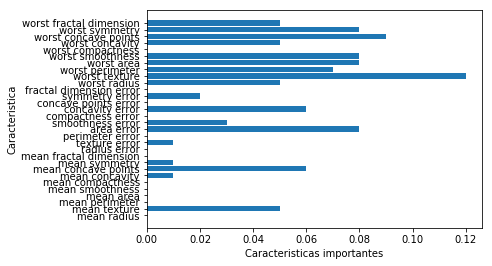

In [11]:
gb_clasificador1= GradientBoostingClassifier(random_state=0, max_depth=1)
gb_clasificador1.fit(X_entrenamiento, y_entrenamiento)

dibuja_caracteristicas_importantes_cancer(gb_clasificador1)

Dado que tanto el gradient boosting, como los bosques aleatorios tienen un buen rendimiento en tipos de datos similares, un enfoque común es probar primero los bosques aleatorios, que funcionan bastante bien. Si los bosques aleatorios funcionan bien pero el tiempo de predicción es escaso, o es importante exprimir el último porcentaje de precisión del modelo de machine learning, gradient boosting a menudo ayuda.


Si desea aplicar gradient boosting a un problema a gran escala, vale la pena examinar el paquete [xgboost](https://xgboost.readthedocs.io/en/latest/) y su interfaz de Python, que en es más rápida y en ocasiones más fácil de sintonizar que la implementación de scikit-learn de Gradient Boosting en muchos conjunto de datos.

### Fortalezas, debilidades y paramétros

Gradient boosting  con árboles aleatorios, se encuentran entre los modelos más potentes y ampliamente utilizados para el aprendizaje supervisado. Su principal inconveniente es que requieren un ajuste cuidadoso de los parámetros y puede llevar mucho tiempo entrenar. De forma similar a otros modelos basados en árboles, el algoritmo funciona bien sin escalar y en una mezcla de características binarias y continuas. Al igual que con otros modelos basados en árboles, a menudo tampoco funciona bien en datos dispersos de gran dimensión.

Los parámetros principales del gradient boosting  el número de árboles, `n_estimadors` y el `learning_rate`, que controla el grado en que cada árbol corrija los errores de los árboles anteriores. Estos dos parámetros están altamente interconectados, ya que `learning_rate` más bajo significa que se necesitan más árboles para construir un modelo de complejidad similar. A diferencia de los bosques aleatorios, donde un valor `n_estimadors` siempre es mejor, el aumento de `n_estimators` en el modelo gradient boosting  conduce a un modelo más complejo, que puede conducir a un sobreajuste.

Una práctica común es ajustar `n_estimators` dependiendo del tiempo y el presupuesto de la memoria y luego buscar sobre diferentes `learning_rate`. Otro parámetro importante es `max_depth` (o alternativamente `max_leaf_nodes`), para
reducir la complejidad de cada árbol. Por lo general, `max_depth` se configura muy bajo para los modelos gradient boosting, a menudo  de no más de cinco divisiones.

